<a href="https://colab.research.google.com/github/fabiobasson/Bi-Master/blob/main/geological_comparative10102021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Pós Graduação Business Intelligence Master PUC-RJ 2021

**Tema:** Geological Image Comparative

# **Descrição geral dos arquivos**

**geological_similarity/: armazena as imagens dos 6 tipos de rochas: **   

* andesite/:diretório das imagens das rochas andesite;
*   gneiss/:diretório das imagens das rochas gneiss;
*   marble:diretório das imagens das rochas marble;
*   quartzite:diretório das imagens das rochas quartzite;
*   rhyolite:diretório das imagens das rochas rhyolite
*   schist:diretório das imagens das rochas schist;

    
Este trabalho se concentrará na análise ....

# Importações das Bibliotecas

In [88]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer

from os import getcwd
import zipfile
import shutil
import numpy as np
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
from PIL import Image
import plotly.express as px
import cv2 as cv
from imutils import paths
import matplotlib.pyplot as plt


from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

# **Verificando as versões do Tensorflow e keras**

In [56]:
print(tf.__version__)

# Instalar Tensorflow
#!pip install tensorflow==2.6.0

# Instalar Keras
!pip install keras --upgrade

2.6.0


In [90]:
# Caso precise, remover os diretorios

#!rm -rf geological_similarity andesite gneiss/ marble/ quartzite/ rhyolite/ schist/
!rm -rf geological_similarity

# **Coleta de dados do Kaglle**

In [91]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.

#!kaggle datasets download fabiobasson/geologicalsimilarity
#! unzip -qq  geologicalsimilarity
!kaggle datasets download tanyadayanand/geological-image-similarity
! unzip -qq geological-image-similarity   

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
chmod: cannot access '/root/.kaggle/kaggle.': No such file or directory
geological-image-similarity.zip: Skipping, found more recently modified local copy (use --force to force download)


# **Criação da estrutura e leitura de diretórios**

In [58]:
andesite_dir = glob.glob('geological_similarity/andesite/*.jpg');gneiss_dir = glob.glob('geological_similarity/gneiss/*.jpg')
marble_dir= glob.glob('geological_similarity/marble/*.jpg');quartzite_dir = glob.glob('geological_similarity/quartzite/*.jpg')
rhyolite_dir = glob.glob('geological_similarity/rhyolite/*.jpg');
schist_dir = glob.glob('geological_similarity/schist/*.jpg')
print(len(andesite_dir));print(len(gneiss_dir)); print(len(marble_dir)); print(len(quartzite_dir));  print(len(quartzite_dir)); print(len(schist_dir))

andesite_df=[];gneiss_df=[];marble_df=[];quartzite_df=[];rhyolite_df=[];schist_df=[]

label1=['andesite','gneiss','marble','quartzite','rhyolite','schist']

for i in andesite_dir:
    andesite_df.append([i,label1[0]])
for j in gneiss_dir:
   gneiss_df.append([j,label1[1]])
for l in marble_dir:
    marble_df.append([l,label1[2]])
for m in quartzite_dir:
    quartzite_df.append([m,label1[3]])
for n in rhyolite_dir:
    rhyolite_df.append([n,label1[4]])
for o in schist_dir:
    schist_df.append([o,label1[5]])
   
df = andesite_df + gneiss_df + marble_df  + quartzite_df + rhyolite_df + schist_df
random.shuffle(df)
len(df)


5000
5000
4998
5000
5000
5000


In [92]:
# Criação do Dataframe
data_df = pd.DataFrame(df,columns=['path','label'])
data_df

,path,label
0,geological_similarity/schist/6YOB2.jpg,schist
1,geological_similarity/gneiss/SR82Q.jpg,gneiss
2,geological_similarity/quartzite/MRIER.jpg,quartzite
3,geological_similarity/gneiss/UUSTK.jpg,gneiss
4,geological_similarity/schist/28R84.jpg,schist
...,...,...
29993,geological_similarity/schist/CR9IV.jpg,schist
29994,geological_similarity/andesite/JLIDN.jpg,andesite
29995,geological_similarity/quartzite/UEJHU.jpg,quartzite
29996,geological_similarity/quartzite/SSXUY.jpg,quartzite


In [93]:
dados=[]
labels=[]

for imagePath in data_df['path']:

      label = imagePath.split(os.path.sep)[-2]

      image = cv.imread(imagePath)
      image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
      image = cv.resize(image, (32, 32))
      
      dados.append(image)
      labels.append(label)
      
print("labels: ", np.unique(labels))

labels:  ['andesite' 'gneiss' 'marble' 'quartzite' 'rhyolite' 'schist']


In [94]:
# Converter os dados e rótulos em matrizes NumPy enquanto dimensiona o pixel

dados = np.array(dados) 
labels = np.array(labels)
labels

array(['schist', 'gneiss', 'quartzite', ..., 'quartzite', 'quartzite',
       'andesite'], dtype='<U9')

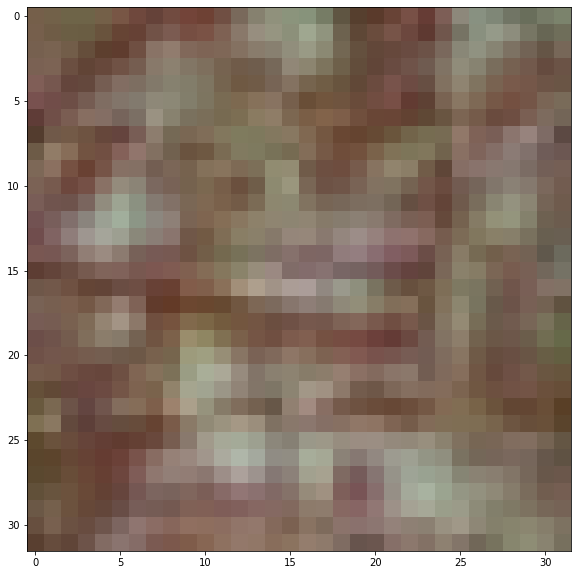

In [95]:
plt.figure(figsize=(10, 10))
plt.imshow(dados[labels=='marble'][5])
plt.show()

In [96]:
lb={'andesite':[1, 0, 0, 0, 0, 0] ,'gneiss':[0, 1, 0, 0, 0, 0] ,'marble':[0, 0, 1, 0, 0, 0], 'quartzite':[0, 0, 0, 1, 0, 0], 'rhyolite':[0, 0, 0, 0, 1, 0], 'schist':[0, 0, 0, 0, 0, 1]}
len(labels)

labels1 = [lb[label] for label in labels]
labels1 = np.array(labels1)
print(labels1)

[[0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]


In [13]:
# executa codificação one-hot nas tags
#lb = LabelBinarizer()
#labels2 = lb.fit_transform(labels)
#labels2 = to_categorical(labels2)
#labels2
#type(labels2)

# **Criando o Dataframe em dados de treino, validação e teste**

In [97]:
X_train, X_test, y_train, y_test  = train_test_split(dados, labels1, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train,test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(17998, 32, 32, 3)
(17998, 6)
(6000, 32, 32, 3)
(6000, 6)
(6000, 32, 32, 3)
(6000, 6)


### **Normalização  **

In [66]:
#X_train = X_train.reshape(X_train.shape[0], 28, 28, 3).astype('float32')
#X_val = X_val.reshape(X_val.shape[0], 28, 28, 3).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 3).astype('float32')

X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

#  Conhecendo os dados de imagem

In [98]:
from numpy import asarray
image = Image.open("geological_similarity/gneiss/0QTQE.jpg")
# Método asarray para realizar a conversão:
pixels= asarray(image)
# Verificando a faixa de valores entre 0 e 255:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

#Converte os valores inteiros em float para realizar a operação:
pixels = pixels.astype('float32')
# Normaliza a faixa de valores:
pixels /= pixels.max()
# Verificando a faixa de valores normalizada:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 32.000, Max: 251.000
Data Type: float32
Min: 0.127, Max: 1.000


# **Limpeza de dados**
1 - Analisando os dados ausentes
2 - Descartando os dados ausentes
3 - Imputando dados
4 - Acrescentando colunas informativas

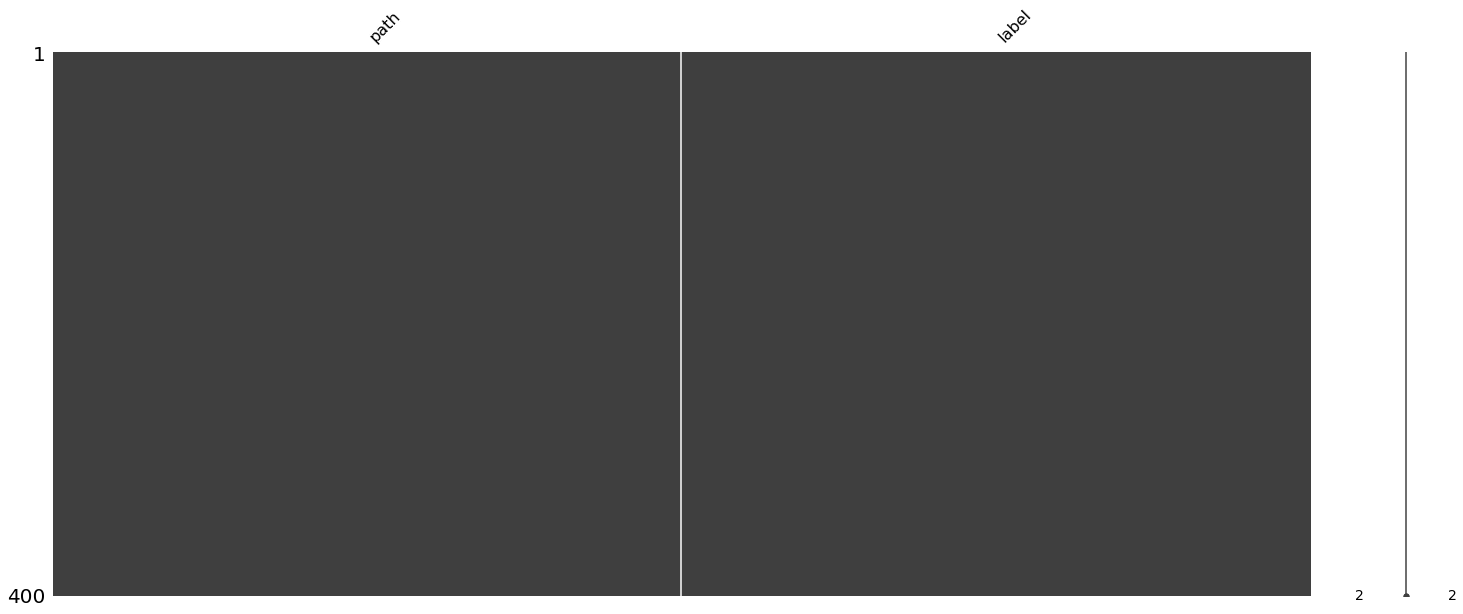

In [68]:
### 1 - Analisando os dados ausentes ###

import missingno as msno
ax = msno.matrix(data_df.sample(400))

# ***Criação dos Parâmetros***

In [99]:
INIT_LR = 1e-3
EPOCHS = 200
BS=24

# **Explorando os dados**


# **Type: Data Augumentation**

## ** Esta função irá plotar as imagens num grid de 1 a 5 colunas **

In [100]:
IMG_SHAPE = 32

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [101]:
# Dados de Treino e Validação

datagen = ImageDataGenerator(rescale=1./255,
                            #featurewise_center =False ,
                            # samplewise_center =False ,
                            # featurewise_std_normalization =False ,
                            # samplewise_std_normalization =False ,
                            # zca_whitening =False ,
                            # zca_epsilon =1e -6 ,
                            # channel_shift_range =0. ,
                            # fill_mode = ’ nearest ’ ,
                            # cval =0. ,
                            rotation_range = 40,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            #shear_range = 0.2,
                            #zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split=0.2)

datagen_val = ImageDataGenerator (rescale=1./255, 
                                 validation_split=0.2)

In [102]:
train_generator = datagen.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='training')

validation_generator = datagen_val.flow_from_dataframe (data_df,
    batch_size=BS,
    x_col='path',
    y_col= 'label',
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='categorical',
    subset='validation')

Found 23999 validated image filenames belonging to 6 classes.
Found 5999 validated image filenames belonging to 6 classes.


In [103]:
# Dados de Teste

datagen_test = ImageDataGenerator (rescale=1./255, 
                                   #validation_split=0.8,
                                  rotation_range = 40)

test_generator = datagen_test.flow_from_dataframe(data_df,
                                                   batch_size=1,
                                                   x_col='path',
                                                   y_col='label',
                                                   shuffle=False,
                                                   target_size=(IMG_SHAPE,IMG_SHAPE),
                                                   class_mode='categorical')
                                                   #subset='validation')

Found 29998 validated image filenames belonging to 6 classes.


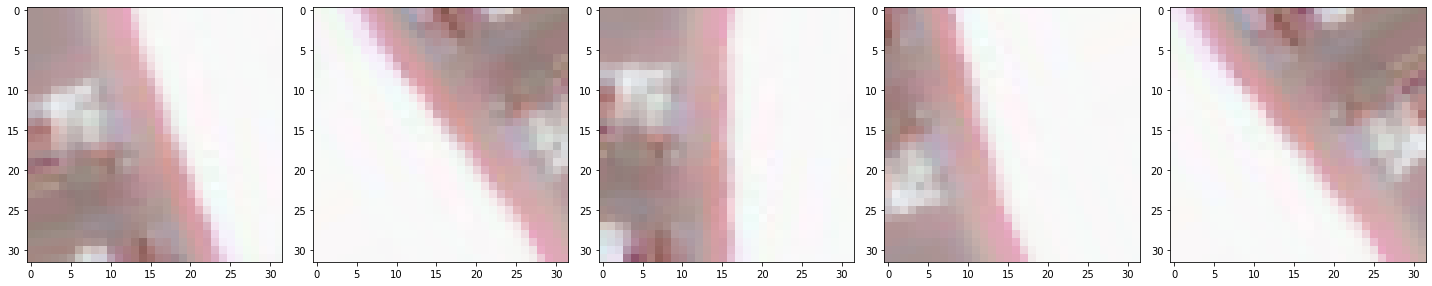

In [78]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [79]:
# comandos importantes
class_dict=test_generator.class_indices
labels= test_generator.labels
file_names= test_generator.filenames 

train_generator.class_indices.keys()

#X_test, y_test = next(test_generator) # não utilizado

dict_keys(['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist'])

# **Criar o modelo**

In [80]:
num_classes = 6

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
   
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
   
])


# **O sumário do modelo Conv2D construído.**

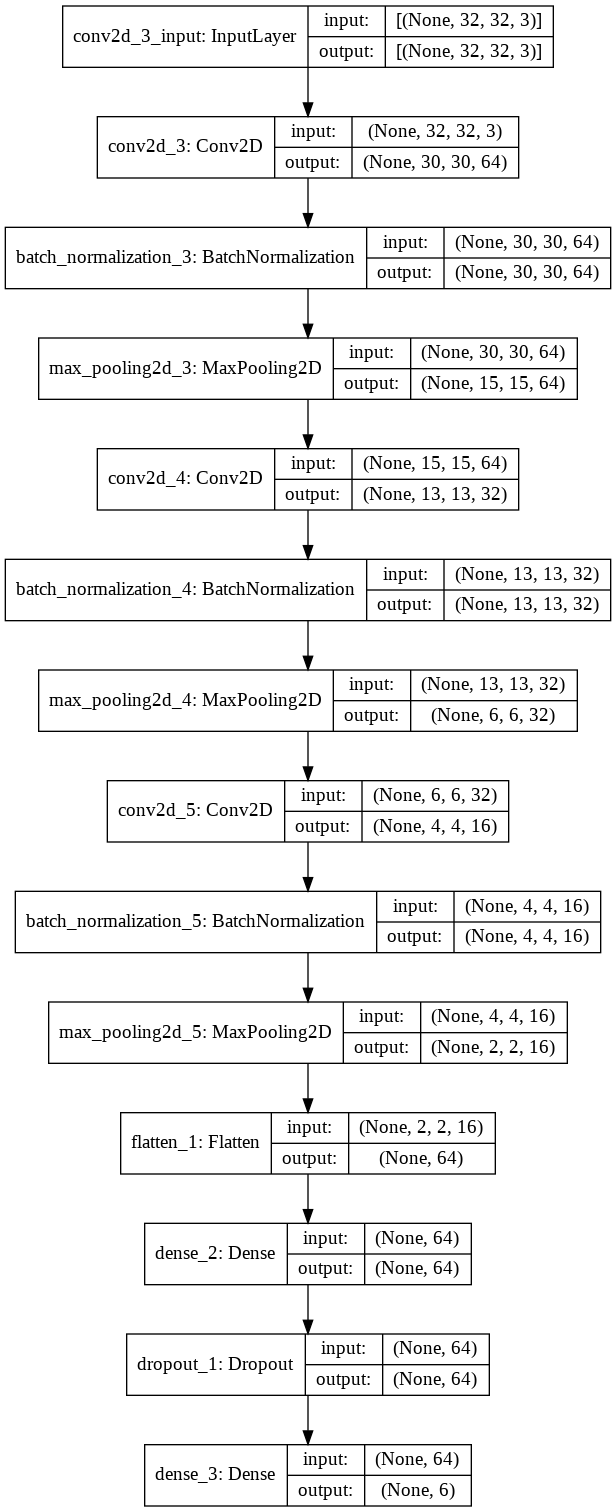

In [81]:
tf.keras.utils.plot_model(model, show_shapes=True)

# **Compilando o Modelo**

In [82]:
model.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])
model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 16)         

In [83]:
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        #save_weights_only=False,
        #mode='auto',
        #period=1,
    ),

]

# ** Treinamento dos modelos
Nesta etapa os modelos são expostos aos exames e suas saídas são comparadas às anotações realizadas pelos médicos, como forma de apurar a diferença na previsão e ajustar os parâmetros da rede em cima do erro identificado, de forma a torná-la mais apta em futuras iterações.

Avaliar o modelo**

In [84]:
# Time (07/10/2021): rodando no ambiente Google Colab 1h e 6min 

history = model.fit(X_train,y_train,
                               epochs=EPOCHS,
                               verbose=1,
                               callbacks=callbacks_list,
                               steps_per_epoch = len(X_train)//BS, 
                               #validation_split=0.2,
                               #class_weight=class_weight_,
                               workers=4,
                               use_multiprocessing=True,
                               validation_steps = len(X_val)//BS,
                               validation_data= (X_val,y_val))

Epoch 1/200
749/749 [==============================] - 7s 8ms/step - loss: 0.8365 - accuracy: 0.6866 - val_loss: 0.3373 - val_accuracy: 0.8850

Epoch 00001: val_accuracy improved from -inf to 0.88500, saving model to best_model.h5
Epoch 2/200
749/749 [==============================] - 6s 8ms/step - loss: 0.3736 - accuracy: 0.8725 - val_loss: 0.1914 - val_accuracy: 0.9285

Epoch 00002: val_accuracy improved from 0.88500 to 0.92850, saving model to best_model.h5
Epoch 3/200
749/749 [==============================] - 6s 8ms/step - loss: 0.2965 - accuracy: 0.9001 - val_loss: 0.1487 - val_accuracy: 0.9487

Epoch 00003: val_accuracy improved from 0.92850 to 0.94867, saving model to best_model.h5
Epoch 4/200
749/749 [==============================] - 6s 8ms/step - loss: 0.2507 - accuracy: 0.9168 - val_loss: 0.1535 - val_accuracy: 0.9488

Epoch 00004: val_accuracy improved from 0.94867 to 0.94883, saving model to best_model.h5
Epoch 5/200
749/749 [==============================] - 6s 8ms/step 

Text(0.5, 1.0, 'Train - Accuracy')

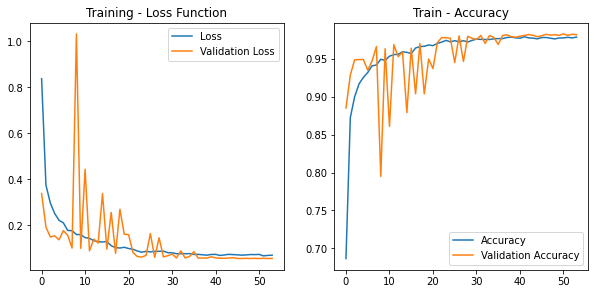

In [85]:
# Deixe-nos representar graficamente a Precisão do treinamento versus perda para obter uma melhor compreensão do treinamento do modelo.
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')


# **Vamos traçar a precisão do treinamento e da validação, bem como a perda.** 

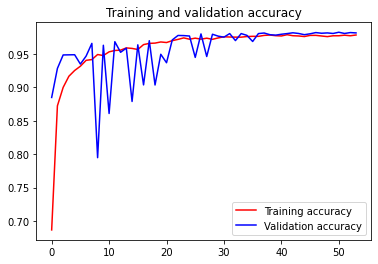

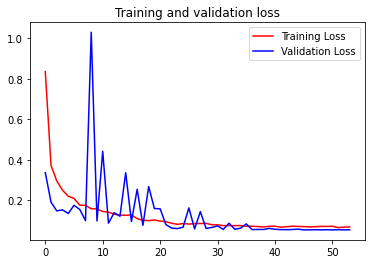

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
#history2= model.history.history
#px.line(history2,title = "Metrics Plot")

# **Avaliar acurácia  do Modelo**

In [87]:
print("Conv2D - resultados")

model = tf.keras.models.load_model("best_model.h5")

test_loss, test_acc= model.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_acc))
print("-------\n")
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")
#hs = hamming_score(y_test.to_numpy(), y_pred)
#print(f"Hamming loss: {hs}")
print("-------\n")

Conv2D - resultados
188/188 [==============================] - 1s 5ms/step - loss: 0.0583 - accuracy: 0.9802
validation_accuracy: 0.9801666736602783
-------

Test accuracy: 0.9801666736602783
Test loss: 0.05830437317490578
-------



# **Realizar as predições para as classes com o modelo criado**

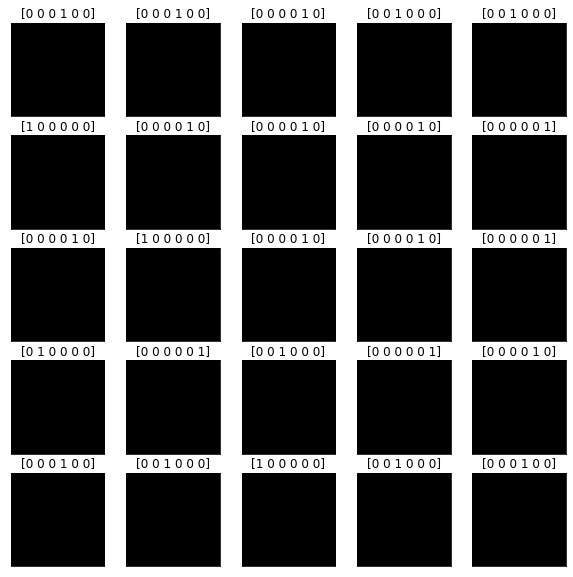

In [40]:
class_names = ['andesite','gneiss','marbler','quartzite','rhyolite','schist']
#class_names = [0,1,2,3,4,5]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
    #plt.xlabel(y_train[i])
plt.show()
   

# **Realizando as predições e as confirmações**

In [41]:
y_pred = model.predict(X_test)
print("Prediction_accuracy: " + str(y_pred))

Prediction_accuracy: [[5.5403143e-06 1.5228079e-04 9.2688964e-08 1.3168853e-06 1.2343746e-08
  9.9984074e-01]
 [2.6204566e-08 9.9965334e-01 1.7948560e-08 7.6870282e-07 2.6358229e-10
  3.4578718e-04]
 [9.7956860e-01 1.8996901e-05 4.9827140e-05 1.0488475e-02 7.1955291e-03
  2.6785252e-03]
 ...
 [5.7342848e-05 4.8243446e-06 7.1397404e-09 9.9993694e-01 2.0611908e-07
  6.0311925e-07]
 [9.1779160e-01 7.9187075e-06 8.2672675e-05 2.6304875e-02 5.5591978e-02
  2.2101791e-04]
 [4.1490179e-01 2.6909365e-05 2.2394156e-04 3.0433694e-03 5.8082342e-01
  9.8053820e-04]]


In [42]:
y_pred[400] #  predição posição 400

array([3.9004408e-02, 1.9602421e-06, 6.0702831e-05, 3.0192188e-03,
       9.5784277e-01, 7.0960006e-05], dtype=float32)

In [43]:
print(np.argmax(y_pred[400])) # Nesse caso, a predição está apontada - Classe 4

4


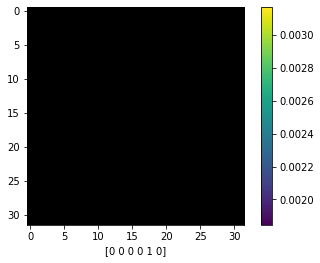

In [44]:
y_test [400] # Nesse caso, a predição está correta - Classe 0, conforme figura abaixo:

plt.figure()
plt.imshow(X_train[400])
plt.xlabel(y_test[400])
plt.colorbar()
plt.grid(False)
plt.show()

In [45]:
y_pred[201] # primeira predição posição 0

array([2.4982393e-04, 5.1636552e-03, 1.0481881e-05, 1.8734623e-04,
       5.4460088e-06, 9.9438322e-01], dtype=float32)

In [46]:
np.argmax(y_pred[201]) # Nesse caso, a predição está correta - Classe 03

5

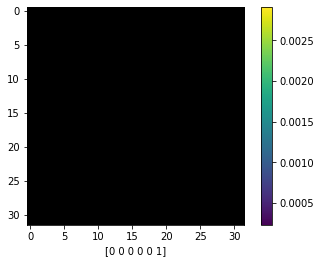

In [47]:
y_test [201] # Nesse caso, a predição está correta - Classe 03, conforme figura abaixo

plt.figure()
plt.imshow(X_train[201])
plt.xlabel(y_test[201])
plt.colorbar()
plt.grid(False)
plt.show()

# ** Modelo treinado para fazer a predição de uma única imagem.**

In [48]:
img = X_test [50]
test_labels_single = y_test [50]
print(img.shape)

test_labels_single

# Adiciona a imagem em um batch que possui um só membro.
img = (np.expand_dims(img,0))

print(img.shape)

(32, 32, 3)
(1, 32, 32, 3)


In [49]:
predictions_single = model.predict(img)

print(predictions_single)

[[9.3384248e-01 3.8605053e-06 9.6706990e-06 8.5695628e-03 3.1766042e-02
  2.5808400e-02]]


In [50]:
predictions_single = np.argmax(predictions_single, axis=1)
predictions_single

array([0])

In [51]:
# Fazer previsões no conjunto de teste
print("[INFO] evaluating network...")
y_pred = model.predict(X_test,batch_size=BS)

# Para cada imagem no conjunto de teste, precisamos encontrar o índice do
# rótulo com a maior probabilidade prevista correspondente
y_pred = np.argmax(y_pred, axis=1)

# Mostra um relatório de classificação bem formatado
print(classification_report(y_test.argmax(axis=1), y_pred,
                            target_names=lb))

[INFO] evaluating network...
              precision    recall  f1-score   support

    andesite       0.95      0.93      0.94      1024
      gneiss       0.95      0.98      0.97       995
      marble       1.00      1.00      1.00       968
   quartzite       0.96      0.97      0.97      1059
    rhyolite       0.97      0.98      0.97       986
      schist       0.97      0.94      0.96       968

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



# **Matriz de Confusão**

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1),y_pred)

# show the confusion matrix
print(cm)

[[ 953    1    1   35   27    7]
 [   0  977    0    1    0   17]
 [   0    0  968    0    0    0]
 [  30    1    0 1026    1    1]
 [  23    0    0    0  963    0]
 [   0   49    0    2    4  913]]


In [53]:
# Calcule a matriz de confusão e use-a para derivar o
# precisão, sensibilidade e especificidade

total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Mostrar a precisão, sensibilidade e especificidade
print("acc: {:.4f}".format(acc))

acc: 0.3217


# **Listando as redes realmente disponíveis em seu Keras**

In [49]:
import tensorflow.keras.applications as app
print(dir(app))

['DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'efficientnet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']


# **O Modelo pre treinado VGG16**
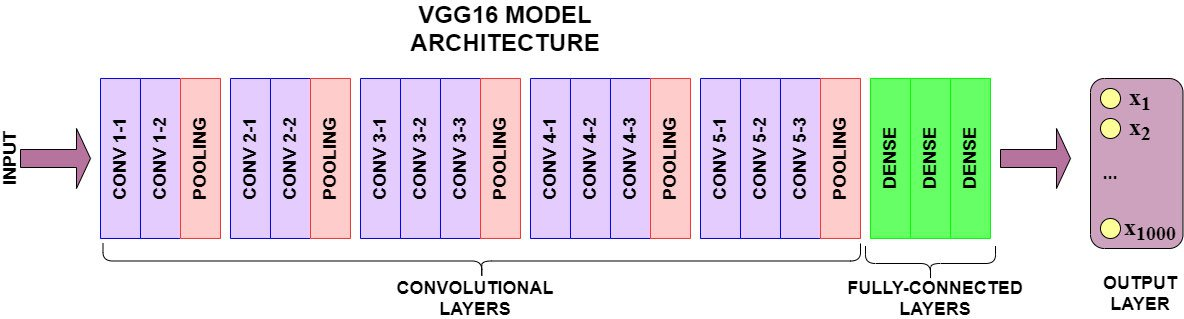

In [50]:
# Inicializar a CNN
classifier = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58900480/58889256 [==============================] - 2s 0us/step


In [51]:
#Listar os Layers do Modelo VGG16
for i,layer in enumerate(classifier.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [52]:
# Marcar as camadas como não treináveis
#for layer in classifier.layers:
   # layer.trainable = False

for layer in classifier.layers[:-2]:
  layer.trainable = False
  print(layer)

# Criar o novo modelo
inputs = tf.keras.Input(shape=(32, 32, 3))
#x = datagen (inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 , offset=-1)
x = scale_layer(inputs)

# Adicionar novas camadas para classificação

x = classifier(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Regularize with dropout
output = Dense(6, activation='softmax')(x)

#flat1 = tf.keras.layers.Flatten()(classifier.layers[-1].output)
#flat1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
#flat1 = tf.keras.layers.Dropout(0.5)(flat1)
#output = Dense(6, activation='softmax')(flat1)

# Definir o modelo
modelvgg16 = Model(inputs=inputs, outputs=output)

modelvgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [53]:
modelvgg16.compile(optimizer = Adam(learning_rate=0.0001), 
               loss = 'categorical_crossentropy', 
               metrics =['accuracy'])  

callbacksvgg16 = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5,
                                         patience=4,
                                         verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="accuracy",
        patience=12,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='feature_extraction.vgg16',
        save_best_only=True,
        monitor="val_accuracy",
    ),

]

In [1]:
historyvgg16 = modelvgg16.fit(X_train,y_train,
                    epochs=EPOCHS,
                    verbose=1,
                    steps_per_epoch = len(X_train)//BS,
                    callbacks=callbacksvgg16,
                    validation_data=(X_val,y_val),
                    validation_steps = len(X_val) //BS)

NameError: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = historyvgg16.history['accuracy']
val_acc = historyvgg16.history['val_accuracy']
loss = historyvgg16.history['loss']
val_loss = historyvgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
modelvgg16 = tf.keras.models.load_model("feature_extraction.vgg16")

test_lossvgg16, test_accvgg16= modelvgg16.evaluate(X_test,y_test)
print("validation_accuracy: " + str(test_accvgg16))

# **Predições Modelo pre treinado VGG16**

In [ ]:
y_predVGG16 = modelvgg16.predict(X_test)
print("Prediction_accuracy: " + str(y_predVGG16))

In [ ]:
y_predVGG16[300]

In [ ]:
print(np.argmax(y_predVGG16[300])) # Nesse caso, a predição está apontada - Classe 4

In [ ]:
y_test [300] # Nesse caso, a predição está correta - Classe 4, conforme figura abaixo

plt.figure()
plt.imshow(X_train[300])
plt.xlabel(y_test[300])
plt.colorbar()
plt.grid(False)
plt.show()

## ** Matriz de confusão com mapa de calor - Código do Prof Leonardo Forero**

In [54]:
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

scratch_preds = model.predict(test_generator)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

KeyboardInterrupt: ignored

In [ ]:
vgg_preds = modelvgg16.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names1 = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names1, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names1, 
        yticklabels=class_names1,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(true_classes, scratch_pred_classes, class_names1, ax1, title="Custom ")    
plot_heatmap(true_classes, vgg_pred_classes, class_names1, ax2, title="Transfer Learning (VGG16)")    
#plot_heatmap(true_classes, vgg_pred_classes_ft, class_names1, ax3, title="Transfer Learning (VGG16) with Fine-Tuning") 

In [ ]:
#Get the predictions for the test data
#predicted_classes = model.predict(X_test)

L = 5
W = 5
fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title("Prediction Class = " )
    axes[i].set_title("Original Class = " )
plt.subplots_adjust(wspace=0.5)

# **Comparação: modelo Criado vs  modelo pre treinado VGG16**

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
acc = [test_acc,test_accvgg16]
model = ['Modelo Criado','Modelo pre treinado VGG16']
#model = ['Modelo Criado','VGG16','InceptionV3','EfficientNetB0','EfficientNetB7']
ax.bar(model,acc)
plt.show()